In [2]:
# 正則化された線形回帰
# 線形回帰の正則化(モデルへの制約)は重みを制限することで実現する
# To support both python 2 and python 3
# お決まりの設定
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [ ]:
# リッジ回帰
# コスト関数に正則化項を加える(バイアスは対象外。重みを減らす)
# スケーリングしておくこと

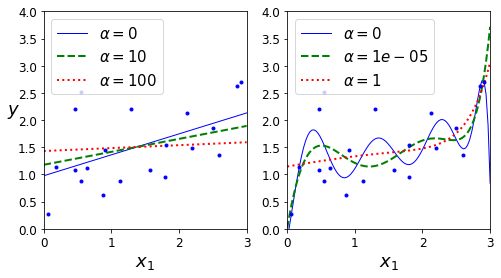

In [7]:
from sklearn.linear_model import Ridge # リッジ回帰
from sklearn.linear_model import LinearRegression # 線形回帰
from sklearn.pipeline import Pipeline # パイプライン
from sklearn.preprocessing import PolynomialFeatures # 多項式
from sklearn.preprocessing import StandardScaler # 標準偏差

# 二次方程式のグラフを作成(ノイズあり)
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)), # 10次多項式
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

plt.savefig("ridge_regression_plot")
plt.show()

In [8]:
#　scikit-learnによるリッジ回帰
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [10]:
# 確率的勾配降下法によるリッジ回帰
# 重みベクトルのl2ノルムの二乗の半分という正則化項
# MSE + l2正則化項(バイアス抜き)

# l1ノルム：MSE 誤差の絶対値の総和 直交する道に沿った形でしか移動できない都市で二つの位置の間を移動するときの距離
# l2ノルム：RMSE 誤差の二乗の総和の平方根　人が普通に考える距離の概念
# ノルムの添え字が大きいほど大きな値を重視し、小さな値を無視する方向に傾く　RMSEはMAEより外れ値の影響を受けやすい
from sklearn.linear_model import SGDRegressor
# 下記のpenaltyがリッジ回帰の制約
sgd_reg = SGDRegressor(max_iter=50, tol=-np.infty, penalty="l2", random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.49905184])

In [ ]:
# Lasso回帰
# 重みベクトルのl1ノルムを使う
# MSE + l1正則化項(バイアス抜き)
# 重要性の低い特徴量の重みを取り除く(0にする)

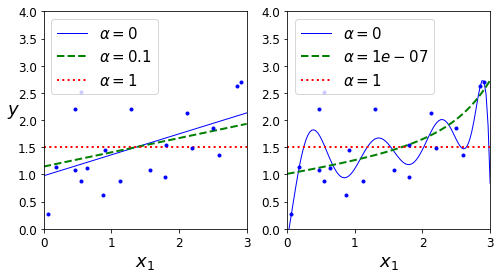

In [11]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), tol=1, random_state=42)

plt.savefig("lasso_regression_plot")
plt.show()

In [12]:
# scikit-learnによるLasso回帰
# Lassoクラスを使う
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

In [13]:
from sklearn.linear_model import SGDRegressor
# 下記のpenaltyがLasso回帰の制約
# panaltyは[l2]がデフォルトで[l1][elasticnet]が選択できる
sgd_reg = SGDRegressor(max_iter=50, tol=-np.infty, penalty="l1", random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.49903849])

In [ ]:
# Elastic Net
# リッジ回帰とLasso回帰の中間　両方を混ぜるが混ぜ方を割合値r で制御する
# r = 0 リッジ回帰
# r = 1 Lasso回帰

# 使い分けについて
# リッジ回帰：デフォルト。意味のある特徴量が多いとき
# Lasso回帰：意味のある特徴量が少ないとき便利。逆に特徴量が多かったり、相関のある特徴量が多いと不安定
# Elastic Net：上記を避けたいとき


In [17]:
# Elastic Net
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42) # 左記のl1_ratioがrの割合を示す
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])



array([4.78114505])

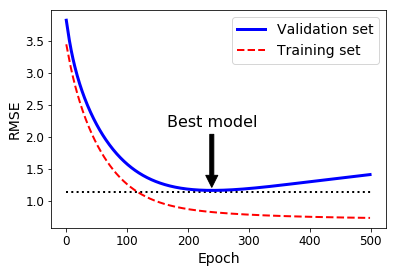

In [18]:
# Early Stopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 二次方程式(ノイズあり)
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

# データ分割
X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

# データ準備
poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)), #90次多項式
        ("std_scaler", StandardScaler()),
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1,
                       tol=-np.infty,
                       penalty=None,
                       eta0=0.0005,
                       warm_start=True,# ここがtrueだと訓練を中断したところから継続する
                       learning_rate="constant",
                       random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train) # 中断したところから継続
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.savefig("early_stopping_plot")
plt.show()

In [19]:
from sklearn.base import clone
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True, penalty=None,
                       learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

In [20]:
best_epoch, best_model

(239, SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.0005,
        fit_intercept=True, l1_ratio=0.15, learning_rate='constant',
        loss='squared_loss', max_iter=1, n_iter=None, penalty=None,
        power_t=0.25, random_state=42, shuffle=True, tol=-inf, verbose=0,
        warm_start=True))